# Setup

In [ ]:
!git clone https://github.com/janljubas/ATNLP-Assignment3.git

In [ ]:
!pip install transformers
!pip install transformers datasets
!pip install pytorch-lightning wandb
!pip install --upgrade transformers torch
!pip install peft
!pip install bitsandbytes

In [ ]:
from peft import LoraConfig, get_peft_model
lora_config = LoraConfig(
    r=16,  # Rank
    lora_alpha=32,
    target_modules=["q", "v"],  # Target T5 attention layers
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"  # Or "SEQ_2_SEQ_LM" depending on your model
)

In [ ]:
from transformers import T5ForConditionalGeneration, TrainingArguments, Trainer

model_name = "t5-base"  # Or "t5-small"
model = T5ForConditionalGeneration.from_pretrained(model_name)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


# Dataset preparation

#### Tokenizer

In [ ]:
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers

# Create a custom tokenizer
tokenizer = Tokenizer(models.BPE())  # Byte-Pair Encoding (BPE) model
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()  # Pre-tokenize by whitespace
tokenizer.decoder = decoders.BPEDecoder()

# Train the tokenizer on your data
trainer = trainers.BpeTrainer(vocab_size=5000, special_tokens=["<pad>", "<unk>", "<s>", "</s>"])
tokenizer.train(files=["/content/ATNLP-Assignment3/data/all_data.txt"], trainer=trainer)

# Save the tokenizer
tokenizer.save("/content/ATNLP-Assignment3/custom_tokenizer.json")


from transformers import PreTrainedTokenizerFast

# tokenizer = T5Tokenizer.from_pretrained(model_name)
tokenizer = Tokenizer.from_file("/content/ATNLP-Assignment3/custom_tokenizer.json")

# Wrap the custom tokenizer
custom_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    pad_token="<pad>",
    unk_token="<unk>",
    bos_token="<s>",
    eos_token="</s>",
)



#### Regular part

In [ ]:
# STEP 1: LOADING DATA AND CREATING ALL 3 SPLITS


# Load the SCAN dataset
def load_scan_data(file_path):
    inputs, outputs = [], []
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith("IN:"):
                # Split the line into input and output parts
                parts = line.strip().split(" OUT: ")
                if len(parts) == 2:
                    inputs.append(parts[0].replace("IN: ", ""))  # Remove "IN: "
                    outputs.append(parts[1])  # Keep the output as is
    return inputs, outputs




# 1.1. loading the training data
train_inputs, train_outputs = load_scan_data("/content/ATNLP-Assignment3/data/Experiment-1/tasks_train_simple.txt")
# print(len(train_inputs), len(train_outputs))

# 1.2. creating the Validation set by splitting the train set 90-10
from sklearn.model_selection import train_test_split

train_inputs, val_inputs, train_outputs, val_outputs = train_test_split(
    train_inputs, train_outputs, test_size=0.1, random_state=42
)
# print(len(train_inputs), len(train_outputs))
# print(len(val_inputs), len(val_outputs))

# 1.3. loading the test data
test_inputs, test_outputs = load_scan_data("/content/ATNLP-Assignment3/data/Experiment-1/tasks_test_simple.txt")
# print(len(test_inputs), len(test_outputs))

In [ ]:
# STEP 2: PREPROCESSING THE DATA
from datasets import Dataset

# tokenize and format the data
def preprocess_scan_data(inputs, outputs, tokenizer, max_length=128):
    formatted_inputs = [f"translate English to Action: {input_text}" for input_text in inputs]
    model_inputs = tokenizer(formatted_inputs, max_length=max_length, truncation=True, padding="max_length")
    labels = tokenizer(outputs, max_length=max_length, truncation=True, padding="max_length").input_ids
    model_inputs["labels"] = labels
    return model_inputs

# preprocess training, validation, and test data
train_data = preprocess_scan_data(train_inputs, train_outputs, custom_tokenizer)
val_data = preprocess_scan_data(val_inputs, val_outputs, custom_tokenizer)
test_data = preprocess_scan_data(test_inputs, test_outputs, custom_tokenizer)

# create Hugging Face Dataset objects
train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    save_steps=500,
    logging_dir="./logs",
    logging_steps=10,
)

# init the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Use validation set if available
    tokenizer=custom_tokenizer,
)

trainer.train()

# model evaluation using the test set
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-85-69465114be6f>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.043600,0.029667
2,0.023400,0.013308
3,0.012200,0.018626


Test Results: {'eval_loss': 0.018611395731568336, 'eval_runtime': 20.9624, 'eval_samples_per_second': 199.5, 'eval_steps_per_second': 24.949, 'epoch': 3.0}


In [ ]:
# Save the model and tokenizer
model.save_pretrained("/content/drive/MyDrive/ATNLP/fine_tuned_t5_custom_model/10_epochs_custom_tokenizer")
custom_tokenizer.save_pretrained("/content/drive/MyDrive/ATNLP/fine_tuned_t5_custom_model/10_epochs_custom_tokenizer")

('/content/drive/MyDrive/ATNLP/fine_tuned_t5_custom_model/10_epochs_custom_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/ATNLP/fine_tuned_t5_custom_model/10_epochs_custom_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/ATNLP/fine_tuned_t5_custom_model/10_epochs_custom_tokenizer/tokenizer.json')


# Experiments



In [ ]:
# Load the fine-tuned model and tokenizer
model = T5ForConditionalGeneration.from_pretrained("/content/ATNLP-Assignment3/models/t5_base/10_epochs_custom_tokenizer")
# tokenizer = T5Tokenizer.from_pretrained("/content/drive/MyDrive/ATNLP/fine_tuned_t5_base_model/10_epochs_custom_tokenizer")
tokenizer = custom_tokenizer


In [ ]:
# Post-processing
def add_spaces_to_output(output_text):
    """
    Adds spaces before each occurrence of "I_" (except the first one).
    """
    # Split the output text into parts based on "I_"
    parts = output_text.split("I_")

    # Reconstruct the text with spaces before "I_" (except the first part)
    reconstructed_text = parts[0]  # First part doesn't need a space
    for part in parts[1:]:
        reconstructed_text += " I_" + part

    return reconstructed_text

# Test the model on a custom input
def model_prediction(input_text):
    input_ids = custom_tokenizer(f"translate English to Action: {input_text}", return_tensors="pt").input_ids
    outputs = model.generate(input_ids)
    decoded_output = custom_tokenizer.decode(outputs[0], skip_special_tokens=True)
    decoded_output_with_spaces = add_spaces_to_output(decoded_output)
    return decoded_output_with_spaces

# Example test
test_input = "run thrice and jump left thrice"
predicted_output = model_prediction(test_input)
print(f"Input: {test_input}")
print(f"Predicted Output: {predicted_output}")


Input: run thrice and jump left thrice
Predicted Output:  I_RUN I_RUN I_RUN I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP


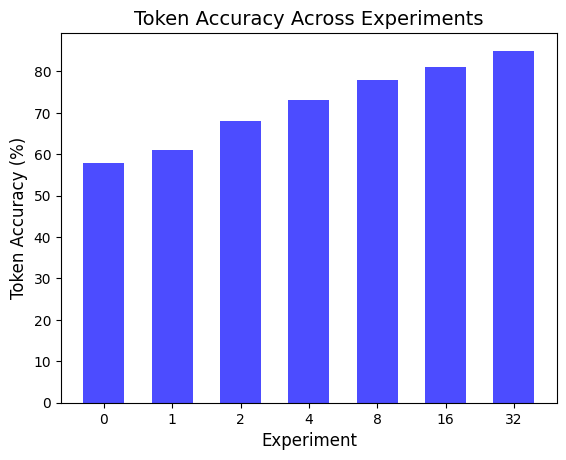

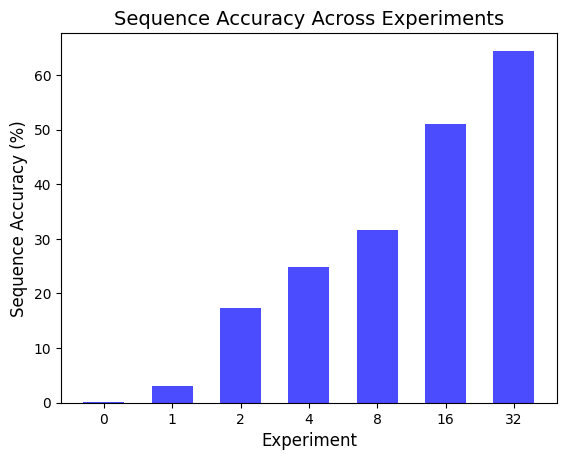

In [38]:
import matplotlib.pyplot as plt

experiment = [0,1,2,4,8,16,32]
token_acc = [58, 61, 68, 73, 78, 81, 85]
seq_acc = [0.001  *100, 0.02972*100, 0.1733*100, 0.2487*100, 0.317*100, 0.511*100, 0.6443*100]

# Adjusting the bar chart to have equal spacing between bars
plt.figure(1)
plt.bar(range(len(experiment)), token_acc, width=0.6, color="blue", alpha=0.7)

# Setting x-ticks to the experiment values and ensuring equal spacing
plt.xticks(range(len(experiment)), experiment)

# Adding labels and title
plt.xlabel("Experiment", fontsize=12)
plt.ylabel("Token Accuracy (%)", fontsize=12)
plt.title("Token Accuracy Across Experiments", fontsize=14)

# Display the plot
plt.show()

plt.figure(2)
plt.bar(range(len(experiment)), seq_acc, width=0.6, color='blue', alpha=0.7)

# Setting x-ticks to the experiment values and ensuring equal spacing
plt.xticks(range(len(experiment)), experiment)

# Adding labels and title
plt.xlabel("Experiment", fontsize=12)
plt.ylabel("Sequence Accuracy (%)", fontsize=12)
plt.title("Sequence Accuracy Across Experiments", fontsize=14)

# Display the plot
plt.show()

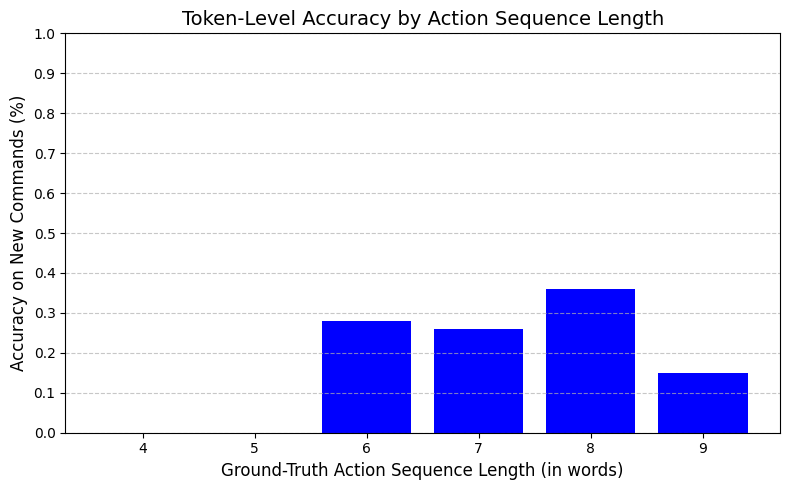

In [52]:

x = [4, 6, 7, 8, 9]
y = [0, 0.28, 0.26, 0.36, 0.15]

# Further adjusting the bar width to create whitespace between columns
plt.figure(figsize=(8, 5))
plt.bar(x, y, width=0.8, color='blue')  # Narrower width for more space

# Add labels and title
plt.title('Token-Level Accuracy by Action Sequence Length', fontsize=14)
plt.xlabel('Ground-Truth Action Sequence Length (in words)', fontsize=12)
plt.ylabel('Accuracy on New Commands (%)', fontsize=12)

# Adjust tick marks
plt.xticks(range(4, 10, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.tight_layout()
plt.show()